In [35]:
import os, glob, math, random, pickle
import numpy as np, pandas as pd, tqdm, torchaudio, torch
import matplotlib.pyplot as plt
from transformers import AutoProcessor, HubertModel

In [19]:
BASE = "/media/dtsarev/SatSSD/data"
AUDIO_DIR  = f"{BASE}/audio"
TRAIN_CSV  = f"{BASE}/train_split.csv"
VAL_CSV    = f"{BASE}/valid_split.csv"
EMB_CACHE  = f"audio_hubert_embeds"
EPOCHS     = 1000
os.makedirs(EMB_CACHE, exist_ok=True)

In [3]:
SR        = 16_000
MAX_SEC   = 12
DEVICE    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMOS = ["Admiration","Amusement","Determination","Empathic Pain","Excitement","Joy"]
NUM_EMOS = len(EMOS)

In [4]:
proc  = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)
model.eval()

@torch.no_grad()
def extract_embed(path:str)->np.ndarray:
    """Return (T, H) HuBERT hidden states for first MAX_SEC seconds of *path* MP3."""
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav[:, : SR*MAX_SEC]
    wav = (wav - wav.mean()) / (wav.std() + 1e-6)  # CMVN
    inp = proc(wav.squeeze(), sampling_rate=SR, return_tensors='pt', padding=True)
    hid = model(**{k: v.to(DEVICE) for k, v in inp.items()}).last_hidden_state[0]  # (T, 768)
    return hid.cpu().numpy()

In [6]:
def cache_all(csv_path:str, tag:str):
    df = pd.read_csv(csv_path, dtype={'Filename': str})
    df['Filename'] = df['Filename'].str.zfill(5)
    for fn in tqdm(df['Filename'], desc=f"{tag} embeds"):
        out = f"{EMB_CACHE}/{tag}_{fn}.npy"
        if os.path.exists(out):
            continue
        mp3 = f"{AUDIO_DIR}/{fn}.mp3"
        try:
            np.save(out, extract_embed(mp3))
        except Exception as e:
            print("skip", fn, e)

cache_all(TRAIN_CSV, "train")
cache_all(VAL_CSV,   "val")

val embeds: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4588/4588 [02:22<00:00, 32.12it/s]


In [30]:
def build_xy(csv_path:str, tag:str, all_stats=True):
    df = pd.read_csv(csv_path, dtype={'Filename':str})
    df['Filename'] = df['Filename'].str.zfill(5)
    X, y = [], []
    for _, row in df.iterrows():
        fn = row['Filename']
        npy = f"{EMB_CACHE}/{tag}_{fn}.npy"
        if not os.path.exists(npy):
            continue
        feat = np.load(npy)  # (T,H)
        if all_stats:
            vec = np.concatenate([feat.mean(0), feat.std(0), feat.min(0), feat.max(0)])
        else:
            vec = feat.mean(0)
        X.append(vec)
        y.append(row[EMOS].values.astype(np.float32))
    return np.stack(X), np.stack(y)

X_train, y_train = build_xy(TRAIN_CSV,'train',True)
X_val,   y_val   = build_xy(VAL_CSV,  'val',  True)
print('Shapes:', X_train.shape, y_train.shape, X_val.shape)

IN_DIM = X_train.shape[1]

Shapes: (8072, 4096) (8072, 6) (4588, 4096)


In [100]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self, in_dim:int, out_dim:int=NUM_EMOS):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 1024), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(512, out_dim)  # no activation
        )
    def forward(self,x):
        return self.net(x)

train_dl = DataLoader(TensorDataset(torch.from_numpy(X_train).float(),
                                    torch.from_numpy(y_train).float()),
                      batch_size=256, shuffle=True)
val_dl   = DataLoader(TensorDataset(torch.from_numpy(X_val).float(),
                                    torch.from_numpy(y_val).float()),
                      batch_size=256, shuffle=False)

model_t = MLP(IN_DIM).to(DEVICE)
opt     = torch.optim.AdamW(model_t.parameters(), lr=5e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=7, min_lr=1e-6)

def pearson_loss(preds, targets):
    vx, vy = preds - preds.mean(0), targets - targets.mean(0)
    corr = (vx*vy).sum(0)/(torch.sqrt((vx**2).sum(0)*(vy**2).sum(0))+1e-8)
    return 1-corr.mean()

In [101]:
train_losses, val_losses = [], []
train_corrs,  val_corrs  = [], []

best=float('inf'); patience=15; wait=0
for epoch in range(1,EPOCHS):
    # --- train
    model_t.train(); tloss=0; preds_e=[]; labels_e=[]
    for xb,yb in train_dl:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = model_t(xb)
        loss = pearson_loss(pred, yb)
        loss.backward(); nn.utils.clip_grad_norm_(model_t.parameters(),1.0); opt.step()
        tloss += loss.item()
        preds_e.append(pred.detach().cpu()); labels_e.append(yb.cpu())
    tloss/=len(train_dl)
    p_train = torch.cat(preds_e); t_train = torch.cat(labels_e)
    train_corr = torch.mean(torch.tensor([np.corrcoef(p_train[:,i], t_train[:,i])[0,1] for i in range(NUM_EMOS)])).item()

    # --- val
    model_t.eval(); vloss=0; vpreds=[]; vlabels=[]
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model_t(xb)
            vloss += pearson_loss(pred,yb).item()
            vpreds.append(pred.cpu()); vlabels.append(yb.cpu())
    vloss/=len(val_dl)
    p_val = torch.cat(vpreds); t_val = torch.cat(vlabels)
    val_corr = torch.mean(torch.tensor([np.corrcoef(p_val[:,i], t_val[:,i])[0,1] for i in range(NUM_EMOS)])).item()

    train_losses.append(tloss); val_losses.append(vloss)
    train_corrs.append(train_corr); val_corrs.append(val_corr)

    print(f"Epoch {epoch:02d}: L_tr {tloss:.4f} | L_val {vloss:.4f} | R_tr {train_corr:.3f} | R_val {val_corr:.3f}")

    if vloss<best:
        best, wait = vloss,0
        torch.save(model_t.state_dict(),'best_audio_mlp.pt'); print('  saved')
    else:
        wait+=1
        if wait>=patience:
            print('Early stop'); break

Epoch 01: L_tr 1.0120 | L_val 0.9692 | R_tr -0.012 | R_val 0.030
  saved
Epoch 02: L_tr 0.9976 | L_val 0.9677 | R_tr -0.000 | R_val 0.032
  saved
Epoch 03: L_tr 0.9893 | L_val 0.9673 | R_tr 0.012 | R_val 0.033
  saved
Epoch 04: L_tr 0.9827 | L_val 0.9650 | R_tr 0.016 | R_val 0.034
  saved
Epoch 05: L_tr 0.9795 | L_val 0.9638 | R_tr 0.021 | R_val 0.036
  saved
Epoch 06: L_tr 0.9612 | L_val 0.9626 | R_tr 0.039 | R_val 0.037
  saved
Epoch 07: L_tr 0.9583 | L_val 0.9572 | R_tr 0.041 | R_val 0.043
  saved
Epoch 08: L_tr 0.9480 | L_val 0.9492 | R_tr 0.051 | R_val 0.051
  saved
Epoch 09: L_tr 0.9281 | L_val 0.9363 | R_tr 0.069 | R_val 0.064
  saved
Epoch 10: L_tr 0.9083 | L_val 0.9030 | R_tr 0.087 | R_val 0.098
  saved
Epoch 11: L_tr 0.8845 | L_val 0.8619 | R_tr 0.103 | R_val 0.140
  saved
Epoch 12: L_tr 0.8616 | L_val 0.8204 | R_tr 0.126 | R_val 0.183
  saved
Epoch 13: L_tr 0.8357 | L_val 0.7962 | R_tr 0.143 | R_val 0.210
  saved
Epoch 14: L_tr 0.8249 | L_val 0.8164 | R_tr 0.157 | R_val 0.18

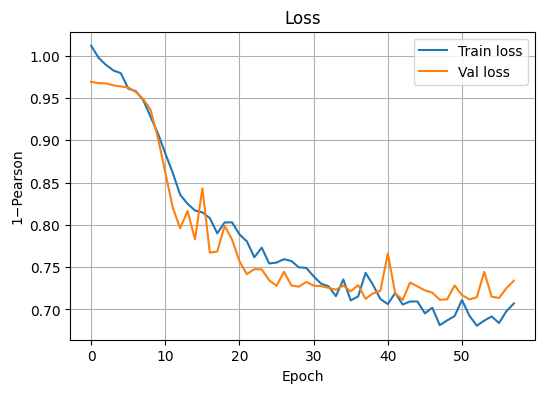

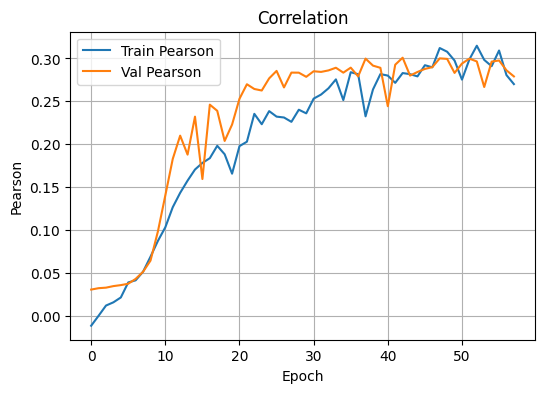

In [102]:
plt.figure(figsize=(6,4));
plt.plot(train_losses,label='Train loss'); plt.plot(val_losses,label='Val loss');
plt.xlabel('Epoch'); plt.ylabel('1−Pearson'); plt.title('Loss'); plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4));
plt.plot(train_corrs,label='Train Pearson'); plt.plot(val_corrs,label='Val Pearson');
plt.xlabel('Epoch'); plt.ylabel('Pearson'); plt.title('Correlation'); plt.legend(); plt.grid(); plt.show()

In [103]:
model_t.load_state_dict(torch.load('best_audio_mlp.pt'))
model_t.eval(); preds=[]
with torch.no_grad():
    for xb,_ in val_dl:
        preds.append(model_t(xb.to(DEVICE)).cpu())
macro_r = np.mean([np.corrcoef(torch.cat(preds).numpy()[:,i], y_val[:,i])[0,1] for i in range(NUM_EMOS)])
print('Macro Pearson on VAL (best):', macro_r)

Macro Pearson on VAL (best): 0.30082552364041343


In [105]:
model_t.load_state_dict(torch.load('best_audio_mlp.pt'))
model_t.eval(); preds=[]
with torch.no_grad():
    for xb,_ in val_dl:
        preds.append(model_t(xb.to(DEVICE)).cpu())

preds = torch.cat(preds).numpy()     # (N,6)
per_emotion_r = [np.corrcoef(preds[:,i], y_val[:,i])[0,1] for i in range(NUM_EMOS)]
macro_r = float(np.mean(per_emotion_r))

print("Per‑emotion Pearson (VAL):")
for emo, r in zip(EMOS, per_emotion_r):
    print(f"  {emo:14s}: {r:.4f}")
print(f"Macro Pearson: {macro_r:.4f}")

best_idx = int(np.argmax(per_emotion_r))
print(f"Highest correlation on VAL for: {EMOS[best_idx]} → {per_emotion_r[best_idx]:.4f}")

Per‑emotion Pearson (VAL):
  Admiration    : 0.3672
  Amusement     : 0.2098
  Determination : 0.2472
  Empathic Pain : 0.4252
  Excitement    : 0.2922
  Joy           : 0.2632
Macro Pearson: 0.3008
Highest correlation on VAL for: Empathic Pain → 0.4252
